## JPS##




Relevant articles are:

-https://www.researchgate.net/publication/333904146_Grid_Pathfinding_on_the_2_k_Neighborhoods

-Canonical Orderings on Grids

-https://www.researchgate.net/publication/221603063_Online_Graph_Pruning_for_Pathfinding_On_Grid_Maps?enrichId=rgreq-ba6335d1aeece8d092b236b991ab03d7-XXX&enrichSource=Y292ZXJQYWdlOzIyMTYwMzA2MztBUzoxMDQ3ODE2Nzg5MDczOTVAMTQwMTk5MzMwNzMxMA%3D%3D&el=1_x_3&_esc=publicationCoverPdf

-More Canonical Ordering

### Importing libraries

In [311]:
import random

from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from random import randint, random, seed
from heapq import heappop, heappush
from time import sleep
from math import hypot
from math import copysign
import heapq
import copy

### Grid map representation 

Square grid map class represents the environment for our moving agent

- width -- the number of columns in the grid
- height -- the number of rows in the grid
- cells -- the binary matrix, that represents the grid. 0 - cell is traversable, 1 - cell is blocked

In [312]:
class Map:

    def __init__(self):
        """
        Default constructor
        """

        self._width = 0
        self._height = 0
        self._cells = []

    def read_from_string(self, cell_str, width, height):
        """
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        """
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '#':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width)

                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height)

    def set_grid_cells(self, width, height, grid_cells):
        """
        Initialization of map by list of cells.
        """
        self._width = width
        self._height = height
        self._cells = grid_cells

    def in_bounds(self, i, j):
        """
        Check if the cell is on a grid.
        """
        return (0 <= j < self._width) and (0 <= i < self._height)

    def traversable(self, i, j):
        """
        Check if the cell is not an obstacle.
        """
        return not self._cells[i][j]

    def is_obstacle(self, i, j):
        if self.in_bounds(i,j):
            if not self.traversable(i,j):
                return True
        return False
    
    def accessible(self, i, j):
        return self.in_bounds(i,j) and self.traversable(i,j)

    def check_move(self, i, j, d):
        return self.accessible(i+d[0], j+d[1])

        if d[0] == 0 or d[1] == 0:
            return self.accessible(i+d[0], j+d[1])
        else:
            return self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]) and self.traversable(i, j + d[1]) and self.traversable(i + d[0], j)

    def get_neighbors(self, i, j):
        """
        Get a list of neighbouring cells as (i,j) tuples.
        It's assumed that grid is 8-connected (i.e. movements in cardinal and diagonal directions are allowed)
        """
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]

        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
                
        delta = [[1, 1], [1, -1], [-1, -1], [-1, 1]]
        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]): #and self.traversable(i, j + d[1]) and self.traversable(i + d[0], j):
                neighbors.append((i + d[0], j + d[1]))

        return neighbors

    def get_size(self):
        return self._height, self._width

### Search Node Representation


In [313]:
class Node:
    """
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node
    - f: f-value of the node
    - parent: pointer to the parent-node
    - k: iteration of the algorithm when the node was visited for the first time. Required for correct breaking-ties
    - g_is_true_cost: flag that shows whether the g-value wath precisely computed or just estimated
    
    You might want to add other fields, methods for Node, depending on how you prefer to implement OPEN/CLOSED further on
    """

    def __init__(self, i, j, g=0, h=0, f=None, parent=None, k=0, g_is_true_cost = False):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        self.k = k
        self.g_is_true_cost = g_is_true_cost
        self.prim = []
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        '''
        Estimating where the two search nodes are the same,
        which is needed to detect dublicates in the search tree.
        '''
        return (self.i == other.i) and (self.j == other.j)
    
    def __hash__(self):
        '''
        To implement CLOSED as set of nodes we need Node to be hashable.
        '''
        ij = self.i, self.j
        return hash(ij)

    def __repr__(self):
        return f'({self.i}, {self.j}, g = {self.g}, f = {self.f})'
        
    def __lt__(self, other) -> object:
        """
        Comparison between self and other. Returns is self < other (self has higher priority).
        """
        return self.f < other.f or ((self.f == other.f) and (self.h < other.h)) \
               or ((self.f == other.f) and (self.h == other.h) and (self.k > other.k))

In [314]:
def compute_cost(i1, j1, i2, j2):
    return hypot(i2-i1, j2-j1)

### Visualization

In [315]:
def draw_local_path(draw, node, k):
    if node.parent is not None:
        draw.line(((node.parent.j+0.5)*k, (node.parent.i+0.5)*k, (node.j+0.5)*k, (node.i+0.5)*k), fill = (0,0,0), width=2)
        draw_local_path(draw, node.parent, k)
    else:
        return


In [316]:
def draw(grid_map, start=None, goal=None, path=None, nodes_opened=None, nodes_expanded=None, edges_evaluated=None):
    '''
    Auxiliary function that visualizes the enviromnet, the path and opened, expanded and reexpanded cells.
    '''
    k = 16
    height, width = grid_map.get_size()
    h_im = height * k
    w_im = width * k
    im = Image.new('RGB', (w_im, h_im), color='white')
    draw = ImageDraw.Draw(im)

    for i in range(height):
        for j in range(width):
            if (not grid_map.traversable(i, j)):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=(70, 80, 80))

    if nodes_opened is not None:
        for node in nodes_opened:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)

    if nodes_expanded is not None:
        for node in nodes_expanded:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(131, 145, 146), width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (grid_map.traversable(step.i, step.j)):
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (grid_map.traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)

    if (goal is not None) and (grid_map.traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)

    #if nodes_opened is not None:
    #    for node in nodes_opened:
    #        draw_local_path(draw, node, k)

    #if nodes_expanded is not None:
    #    for node in nodes_expanded:
    #        draw_local_path(draw, node, k)

    if edges_evaluated is not None:
        for edge in edges_evaluated.keys():
            draw.line(((edge[1] + 0.5) * k, (edge[0] + 0.5) * k, (edge[3] + 0.5) * k, (edge[2] + 0.5) * k), fill=((0, 0, 0) if edges_evaluated[edge] else (200, 200, 200)), width=2)

    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()


### Implementing search tree

In [317]:
class SearchTreePQS: #SearchTree which uses PriorityQueue for OPEN and set for CLOSED
    def __init__(self):
        self._closed = set() 
        self._open = []      
        self._enc_open_dublicates = 0
                
    def __len__(self):
        return len(self._open) + len(self._closed)

    def clear(self):
        self._closed.clear()
        self._open.clear() 
        self._enc_open_dublicates = 0                 
    '''
    open_is_empty should inform whether the OPEN is exhausted or not.
    In the former case the search main loop should be interrupted.
    '''
    def open_is_empty(self):
        return len(self._open) == 0

    '''
    Adding a (previously not expanded) node to the search-tree (i.e. to OPEN).
    It's either a totally new node (the one we never encountered before)
    or it can be a dublicate of the node that currently resides in OPEN.
    It's up to us how to handle dublicates in OPEN. We can either 
    detect dublicates upon adding (i.e. inside this method) or detect them
    lazily, when we are extracting a node for further expansion.
    Not detecting dublicates at all may work in certain setups but let's not
    consider this option.
    ''' 

    def add_to_open(self, item):
        heappush(self._open, item)

    def forced_add_to_open(self, item):
        try:
            idx = self._open.index(item)
            del self._open[idx]
            heapq.heapify(self._open)
            heapq.heappush(self._open, item)
            if self.was_expanded(item):
                self._closed.remove(item)
        except:
            heapq.heappush(self._open, item)

    '''
    Extracting the best node (i.e. the one with the minimal key
    = min f-value = min g-value (for Dijkstra)) from OPEN.
    This node will be expanded further on in the main loop of the search.
    ''' 
    def get_best_node_from_open(self):
        best = heapq.heappop(self._open)
        while self.was_expanded(best):
            if self.open_is_empty():
                return None

            best = heapq.heappop(self._open)
            self._enc_open_dublicates += 1
            
        return best

    def add_to_closed(self, item):
        self._closed.add(item)

    def was_expanded(self, item):
        return item in self._closed

    def expanded(self):
        return self._closed

    def open(self):
        return self._open

    @property
    def OPEN(self):
        return self._open

    @property
    def CLOSED(self):
        return list(self._closed)

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates


### Validating the results

In [318]:
def make_path(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

`simple_test` tests the pathfing algorithm on a single simple instance. Returns same result as search function. Both tests assume that the search function fits the following pattern:

`search(task_map, s.i, s.j, g.i, g.j, *optional arguments*) -> (path_found, last_state, expansions, transitions_computed, nodes_created, open, expanded, edges)`, where

- `task_map` -- grid
- `s.i, s.j` -- (i,j) coordinates of the start cell
- `g.i, g.j` -- (i,j) coordinates of the goal cell
- `*optional arguments*` -- additional parameters of the search function, passed with `*args`.

- `path_found` -- `True` if path was found, `False` otherwise
- `last_state` -- last state of the path. `None` if path was not found
- `expansions` -- the number of the expanded nodes
- `transitions_computed` -- the number of the transitions that were precisely computed (i.e. the numeber of the edges evalations)
- `nodes_created` -- the number of nodes, which were created and stored during the search process (size of the resultant search tree) 
- `open` -- iterable collection of OPEN nodes
- `expanded` --  iterable collection of the expanded nodes (if no re-expansions happening, this is CLOSED)
- `edges` -- dictionary of edges. Each entry says whether the corresponding transition was precisely computed or just estimated. Optional parameter to compare A* with LazyA*. Keys of dictionary should be the coordinates of the corresponding nodes - (i1,j1,i2,j2), values - True if the corresponding transition was precisely computed or False if it was only estimated.   


In [319]:
def simple_test(search_func, task, *args):
    """
    simple_test runs search_func on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task
    """

    height = 15
    width = 30
    map_str = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . .  
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

    task_map = Map()
    task_map.read_from_string(map_str, width, height)
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4), (5, 6)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29), (6, 6)]
    lengths = [40.848, 30.013, 35.294, 20.632, 34.069, 29.416, 38.448, 26.402, 44.959, 24.66, 40.665, 46.738, 29.128, 29.392, 44.189, 37.545, 44.753, 36.602, 44.814, 38.745, 36.396, 34.936, 33.12, 44.632, 44.859, 2]

    if (task is None) or not (0 <= task < 26):
        task = randint(0, 24)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    length = lengths[task]
    result = search_func(task_map, start.i, start.j, goal.i, goal.j, *args)
    try:
        result = search_func(task_map, start.i, start.j, goal.i, goal.j, *args)
        expansions = result[2]
        transitions_computed = result[3]
        nodes_created = result[4]
        if result[0]:
            path = make_path(result[1])
            correct = abs(float(path[1]) - float(length)) < 0.01
            draw(task_map, start, goal, path[0], *result[5:])
            print(f"Path found! Length: {round(path[1],3)}. Nodes created: {nodes_created}. Number of expansions: {expansions}. Transitions computed: {transitions_computed}. Correct: {correct}")
        else:
            path = [[start]]
            draw(task_map, start, goal, path[0], *result[5:])
            print("Path not found!")
        return result

    except Exception as e:
        print("Execution error")
        print(e)

In [320]:
def read_task_from_file(path):
    '''
    Reads map, start/goal positions and true value of path length between given start and goal from file by path. 
    '''

    tasks_file = open(path)
    height = int(tasks_file.readline())
    width = int(tasks_file.readline())
    cells = [[0 for _ in range(width)] for _ in range(height)]
    i = 0
    j = 0

    for l in tasks_file:
        j = 0
        for c in l:
            if c == '.':
                cells[i][j] = 0
            elif c == '#':
                cells[i][j] = 1
            else:
                continue
            j += 1
            
        if j != width:
            raise Exception("Size Error. Map width = ", j, ", but must be", width, "(map line: ", i, ")")
                
        i += 1
        if(i == height):
            break
    
    start_i = int(tasks_file.readline())
    start_j = int(tasks_file.readline())
    goal_i = int(tasks_file.readline())
    goal_j = int(tasks_file.readline())
    length = float(tasks_file.readline())
    return (width, height, cells, start_i, start_j, goal_i, goal_j, length)


In [321]:
def gen_random_tasks(grid_map, N = 10):
    
    def check_task(grid_map, start_i, start_j, goal_i, goal_j):
        return grid_map.accessible(start_i, start_j) and grid_map.accessible(goal_i, goal_j) 
        
    height = grid_map._height
    width = grid_map._width
    start_i = start_j = goal_i = goal_j = -1
    for n in range(N):
        while not check_task(grid_map, start_i, start_j, goal_i, goal_j):
            start_i = int(random.random() * height * 1/2)
            start_j = int(random.random() * width * 1/2)
            start_i = int(height * 1/2) + int(random.random() * height * 1/2)
            start_j = int(width * 1/2) + int(random.random() * width * 1/2)
        yield start_i, start_j, goal_i, goal_j

In [322]:
def massive_test(search_func, data_path, num_of_tasks=None, *args):
    '''
    massive_test runs search_func on set of differnt tasks (from directory data/) 
    with *args as optional arguments and 
    for every task displays the short report:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task.
    
    the function also returns a dictionary with statistics. 
    It contains the next fields:
     - "corr" -- the correctness of every path length (True/False)
     - "len" -- the length of every path (0.0 if path not found)
     - "nc" -- the number of created nodes for every task execution
     - "st" -- the number of steps of algorithm for every task execution
    '''
    
    stat = dict()
    stat["corr"] = []
    stat["len"] = []
    stat["nc"] = []
    stat["st"] = []
    
    if (num_of_tasks is None) or (num_of_tasks<=0):
        print("Incorrect number of tasks. Testing halted!")
        return stat
    
    task_num = num_of_tasks
    task_map = Map()
    for task_count in range(task_num):
        task_file_name = data_path + str(task_count) + ".map"
        width, height, cells, start_i, start_j, goal_i, goal_j, length = read_task_from_file(task_file_name)
        task_map.set_grid_cells(width, height, cells)
        try:
            result = search_func(task_map, start_i, start_j, goal_i, goal_j, *args)
            number_of_steps = result[2]
            nodes_created = result[3]
            if result[0]:
                path = make_path(result[1]) 
                stat["len"].append(path[1])
                correct = int(path[1])  == int(length)
                stat["corr"].append(correct)

                print("Path found! Length: " + str(path[1]) +\
                    ". Nodes created: " + str(nodes_created) + \
                    ". Number of steps: " + str(number_of_steps) + \
                    ". Correct: " + str(correct))
            else:
                print("Path not found!")
                stat["corr"].append(False)
                stat["len"].append(0.0)

            stat["nc"].append(nodes_created)
            stat["st"].append(number_of_steps)

        except Exception as e:
            print("Execution error")
            print(e)

    return stat


In [323]:
def massive_test_random(search_func, data_path, num_of_tasks=None, *args):
    '''
    massive_test runs search_func on set of differnt tasks (from directory data/) 
    with *args as optional arguments and 
    for every task displays the short report:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task.
    
    the function also returns a dictionary with statistics. 
    It contains the next fields:
     - "corr" -- the correctness of every path length (True/False)
     - "len" -- the length of every path (0.0 if path not found)
     - "nc" -- the number of created nodes for every task execution
     - "st" -- the number of steps of algorithm for every task execution
    '''
    
    stat = dict()
    stat["corr"] = []
    stat["len"] = []
    stat["nc"] = []
    stat["st"] = []
    
    if (num_of_tasks is None) or (num_of_tasks<=0):
        print("Incorrect number of tasks. Testing halted!")
        return stat
    
    task_num = num_of_tasks
    task_map = Map()
    for task_count in range(task_num):
        task_file_name = data_path + str(task_count) + ".map"
        width, height, cells, start_i, start_j, goal_i, goal_j, length = read_task_from_file(task_file_name)
        task_map.set_grid_cells(width, height, cells)
        try:
            result = search_func(task_map, start_i, start_j, goal_i, goal_j, *args)
            number_of_steps = result[2]
            nodes_created = result[3]
            if result[0]:
                path = make_path(result[1]) 
                stat["len"].append(path[1])
                correct = int(path[1])  == int(length)
                stat["corr"].append(correct)

                print("Path found! Length: " + str(path[1]) +\
                    ". Nodes created: " + str(nodes_created) + \
                    ". Number of steps: " + str(number_of_steps) + \
                    ". Correct: " + str(correct))
            else:
                print("Path not found!")
                stat["corr"].append(False)
                stat["len"].append(0.0)

            stat["nc"].append(nodes_created)
            stat["st"].append(number_of_steps)

        except Exception as e:
            print("Execution error")
            print(e)

    return stat


### Tools

In [324]:
def diagonal_distance(i1, j1, i2, j2):
    """
    Function to compute heuristic function for the case of 8-connected grids using diagonal(octile) distance
    """
    di = abs(i1-i1)
    dj = abs(j1-j2)
    return min(di, dj)*(math.sqrt(2)-1) + max(di,dj)

def euclidean_distance(i1, j1, i2, j2):
    return hypot(i1-i2, j1-j2)

In [325]:
from math import copysign

moves = [[0, -1], [0, 1], [-1, -1], [-1, 1], [1, -1], [1, 1], [-1, 0], [1, 0]]

def isDiagonal(d):
        return d[0] != 0 and d[1] != 0
        
def isCanonical(d_p, d):
    if d_p == d:
        return True
    elif d_p[0] == -d[0] and d_p[1] == -d[1]:
        return False
    
    if isDiagonal(d_p):
        if isDiagonal(d):
            return False
        else:
            return d[0] == d_p[0] or d[1] == d_p[1]
    else:
        return d[0] == d_p[0] and d[1] == d_p[1]

def hasForced(p, x, grid_map):
    d_p_i = 0 if x[0] - p[0] == 0 else int(copysign(1, x[0] - p[0]))
    d_p_j = 0 if x[1] - p[1] == 0 else int(copysign(1, x[1] - p[1]))
    d_p = [d_p_i, d_p_j]

    if isDiagonal(d_p):
        if grid_map.is_obstacle(x[0] - d_p[0], x[1]):
            return grid_map.check_move(x[0], x[1], [-d_p[0], d_p[1]])
            # return grid_map.accessible(x[0]-d_p[0], x[1] + d_p[1])
        if grid_map.is_obstacle(x[0], x[1] - d_p[1]):
            return grid_map.check_move(x[0], x[1], [d_p[0], -d_p[1]])
            # return grid_map.accessible(x[0] + d_p[0], x[1]-d_p[1])
    else:
        if grid_map.is_obstacle(x[0] + d_p[1], x[1] + d_p[0]):
            return grid_map.check_move(x[0], x[1], [d_p[0] + d_p[1],d_p[1] + d_p[0]])
            # return grid_map.accessible(x[0] + d_p[0] + d_p[1], x[1] + d_p[1] + d_p[0])
        if grid_map.is_obstacle(x[0] - d_p[1], x[1] - d_p[0]):
            return grid_map.check_move(x[0], x[1], [d_p[0] - d_p[1],d_p[1] - d_p[0]])
            # return grid_map.accessible(x[0] + d_p[0] - d_p[1], x[1] + d_p[1] - d_p[0])
    return False

def step(x, d):
    return [x[0] + d[0], x[1] + d[1]]

def jump(x, d, g, grid_map, bound, steps = 0):
    n = step(x,d)
    nbrs = [None]
    if not grid_map.check_move(x[0], x[1], d):
        return [None]
    if n == g:
        return [n]
    if hasForced(x, n, grid_map):
        return [n]
    if isDiagonal(d):
        if bound > 0:
            steps += 1
        if steps == bound:
            return [n]
        else:
            if jump(n, [d[0], 0], g, grid_map, bound, steps) is not None:
                nbrs.append(n)
            if jump(n, [0, d[1]], g, grid_map, bound, steps) is not None:
                nbrs.append(n)
            return nbrs


    if bound > 0:
            steps += 1
    if steps == bound:
            return [n]
    else:
        return jump(n, d, g, grid_map, bound, steps)


def prune(x, grid_map):
    p = x.parent
    if p is None:
        return grid_map.get_neighbors(x.i, x.j)

    neighbors = []
    d_p_i = 0 if x.i - p.i == 0 else int(copysign(1, x.i - p.i))
    d_p_j = 0 if x.j - p.j == 0 else int(copysign(1, x.j - p.j))
    d_p = [d_p_i, d_p_j]
    for mv in moves:
        if isCanonical(d_p, mv):
            neighbors.append([x.i + mv[0], x.j + mv[1]])

    if isDiagonal(d_p):
        if grid_map.is_obstacle(x.i - d_p[0], x.j):
            neighbors.append([x.i-d_p[0], x.j + d_p[1]])
        if grid_map.is_obstacle(x.i, x.j - d_p[1]):
            neighbors.append([x.i + d_p[0], x.j-d_p[1]])
    else:
        if grid_map.is_obstacle(x.i + d_p[1], x.j + d_p[0]):
            neighbors.append([x.i + d_p[0] + d_p[1], x.j + d_p[1] + d_p[0]])
        if grid_map.is_obstacle(x.i - d_p[1], x.j - d_p[0]):
            neighbors.append([x.i + d_p[0] - d_p[1], x.j + d_p[1] - d_p[0]])
    return neighbors

def jps_successors(x, g, grid_map, bound):
    successors = []
    neighbors = prune(x, grid_map)
    for n in neighbors:
        for node in jump([x.i, x.j], [n[0] - x.i, n[1] - x.j], g, grid_map, bound):
            if node is not None:
                successors.append(node)
    return successors

### Algorihms

`astar(task_map, s.i, s.j, g.i, g.j, *optional arguments*) -> (path_found, last_state, expansions, transitions_computed, nodes_created, open, expanded, edges)`, where

- `task_map` -- grid
- `s.i, s.j` -- (i,j) coordinates of the start cell
- `g.i, g.j` -- (i,j) coordinates of the goal cell
- `*optional arguments*` -- additional parameters of the search function, passed with `*args` (heuristic function, search tree data structure)

- `path_found` -- `True` if path was found, `False` otherwise
- `last_state` -- last state of the path. `None` if path was not found
- `expansions` -- the number of the expanded nodes
- `transitions_computed` -- the number of the transitions that were precisely computed (i.e. the numeber of the edges evalations)

- `nodes_created` -- the number of nodes, which were created and stored during the search process (size of the resultant search tree) 
- `open` -- iterable collection of OPEN nodes
- `expanded` --  iterable collection of the expanded nodes (if no re-expansions happening, this is CLOSED)

- `edges` -- dictionary of edges. Each entry says whether the corresponding transition was precisely computed or just estimated. Optional parameter to compare A* with LazyA*. Keys of dictionary should be the coordinates of the corresponding nodes - (i1,j1,i2,j2), values - True if the corresponding transition was precisely computed or False if it was only estimated.

In [326]:
def astar(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None):
    ast = search_tree()
    steps = 0
    nodes_created = 0
    expansions = 0
    transitions_computed = 0
    
    EDGES = dict()
    
    start = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j), k=steps)
    goal = Node(goal_i, goal_j, g=10e9, h = 0, k = 10e9)
    ast.add_to_open(start)
    while not ast.open_is_empty():
        steps += 1
        curNode = ast.get_best_node_from_open()
        if curNode == goal:
            nodes_created = len(ast)
            CLOSED = ast.expanded()
            expansions = len(CLOSED)
            OPEN = ast.open()
            return True, curNode, expansions, transitions_computed, nodes_created, OPEN, CLOSED, EDGES
        neighbors = grid_map.get_neighbors(curNode.i, curNode.j)
        for node in neighbors:
            newNode = Node(i = node[0], j = node[1])
            if not ast.was_expanded(newNode):
                newNode.g = curNode.g + compute_cost(curNode.i, curNode.j, newNode.i, newNode.j)
                transitions_computed += 1
                EDGES[(curNode.i, curNode.j, newNode.i, newNode.j)] = True
                newNode.h = heuristic_func(newNode.i, newNode.j, goal_i, goal_j)            
                newNode.f = newNode.g + newNode.h
                newNode.parent = curNode
                newNode.k = steps
                ast.add_to_open(newNode)
        ast.add_to_closed(curNode)

    CLOSED = ast.expanded()
    nodes_created = len(ast)
    return False, None, expansions, transitions_computed, nodes_created, None, CLOSED, EDGES

In [327]:
def jps(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None, bound = -1):
    ast = search_tree()
    steps = 0
    nodes_created = 0
    expansions = 0
    transitions_computed = 0
    
    EDGES = dict()
    
    start = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j), k=steps)
    goal = Node(goal_i, goal_j, g=10e9, h = 0, k = 10e9)
    ast.add_to_open(start)
    while not ast.open_is_empty():
        steps += 1
        curNode = ast.get_best_node_from_open()
        if curNode == goal:
            nodes_created = len(ast)
            CLOSED = ast.expanded()
            expansions = len(CLOSED)
            OPEN = ast.open()
            EDGES[(curNode.i, curNode.j, curNode.parent.i, curNode.parent.j)] = True
            return True, curNode, expansions, transitions_computed, nodes_created, OPEN, CLOSED, EDGES
        neighbors = jps_successors(curNode, [goal_i, goal_j], grid_map, bound)
        for node in neighbors:
            newNode = Node(i = node[0], j = node[1])
            if not ast.was_expanded(newNode):
                newNode.g = curNode.g + compute_cost(curNode.i, curNode.j, newNode.i, newNode.j)
                transitions_computed += 1
                EDGES[(curNode.i, curNode.j, newNode.i, newNode.j)] = True
                newNode.h = heuristic_func(newNode.i, newNode.j, goal_i, goal_j)            
                newNode.f = newNode.g + newNode.h
                newNode.parent = curNode
                newNode.k = steps
                ast.add_to_open(newNode)
        ast.add_to_closed(curNode)

    CLOSED = ast.expanded()
    nodes_created = len(ast)
    return False, None, expansions, transitions_computed, nodes_created, None, CLOSED, EDGES

### Testing

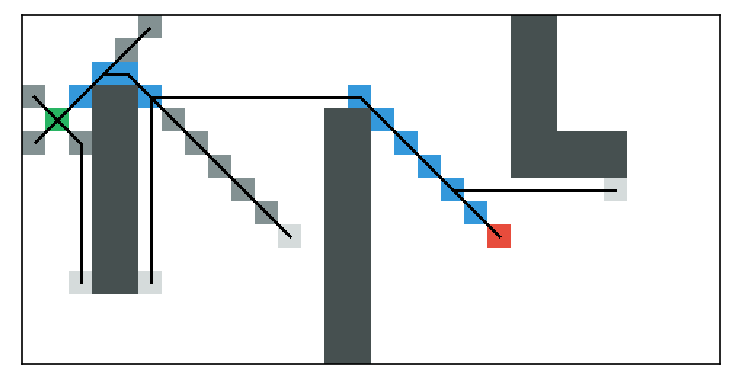

Path found! Length: 22.728. Nodes created: 26. Number of expansions: 21. Transitions computed: 44. Correct: False
CPU times: user 127 ms, sys: 8.67 ms, total: 135 ms
Wall time: 136 ms


In [335]:
%time res = simple_test(jps, 4, diagonal_distance, SearchTreePQS, -1)

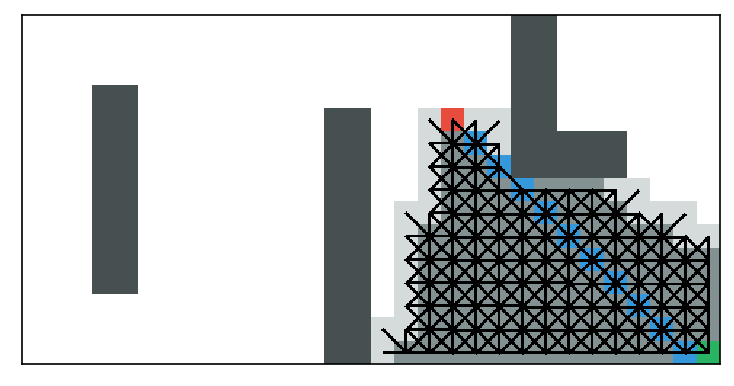

Path found! Length: 15.142. Nodes created: 200. Number of expansions: 97. Transitions computed: 381. Correct: False
CPU times: user 118 ms, sys: 10.9 ms, total: 129 ms
Wall time: 131 ms


In [329]:
%time res = simple_test(astar, 3, diagonal_distance, SearchTreePQS)